
# Setup Code



Import statements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm as gaussian  # not secure normal
from scipy.stats import laplace  # not secure laplace
from scipy.stats import bernoulli # not secure coin flip
from scipy.stats import geom as geometric


# Privacy loss random variables

#### Plotting code:

In [ ]:
def sample_plrv(d1, d2, mechanism, mech_params, logdensity, num_samples=100_000):
  """ Creates samples for the privacy loss random variable for d1, d2
  Inputs:
      d1: the database that determines the distribution of a mechanisms outputs
      d2: the alternative database
      mechanism: the mechanism for which the plrv is being estimated
      mech_params: the additional parameters the mechanism needs, 
                   combined together into a tuple
      logdensity: a function that, given a mechanism output, the input, and its 
                  params, computes the log of the density
      num_samples: how many samples to draw from the distribution of the plrv
  Output:
      an array of sample from the distribution of the plrv
  """
  values = np.zeros(num_samples)
  for i in range(values.size):
      output = mechanism(d1, *mech_params)
      v = logdensity(output, d1, *mech_params) - logdensity(output, d2, *mech_params) # get the value of the plrv 
      values[i]=v
  return values


def samples_to_cdf(samples, num_points=1_000):
    """ Given samples from a random variable, approximate its cdf 
    Inputs: 
       samples: an array of samples
       num_points: number of points inside (0,1) at which to estimate the cdf
    Output:
       (x,y) where x is a set of `num_points` numbers, in sorted order 
             from 0 to 1 and y is array of estimated cdfs at those points
    """
    tolerance = 1e-7
    rangefrac=0.1
    sorted_samples = np.array(sorted(samples))
    num_samples = sorted_samples.size
    smallest_value = sorted_samples.min()
    largest_value = sorted_samples.max()
    therange = largest_value - smallest_value 
    # get left end point of cdf estimate
    next_smallest = sorted_samples[sorted_samples > smallest_value + tolerance].min()
    left = smallest_value - max(next_smallest - smallest_value, rangefrac * therange)
    # get right end point of cdf estimate
    next_largest = sorted_samples[sorted_samples < largest_value - tolerance].max()
    right = largest_value + max(largest_value - next_largest, rangefrac * therange)
    x = np.linspace(left, right, num_points+2)
    y = np.zeros(x.size)

    numless = 0  # used to compute value of cdf at a point
    value_index = 0
    for i in range(x.size):
        point = x[i]
        # compute number of sorted samples <= x[i]
        while value_index < num_samples and sorted_samples[value_index] <= point:
          numless = numless + 1
          value_index = value_index + 1
        y[i] = numless / num_samples
    return x,y


def plot_plrv(d1, d2, mechanism, mech_params, logdensity, num_samples=100_000, num_points=1_000, both=True, title=""):
    """ Prepares the plot the CDF of the plrv, you have to call plt.show
    Inputs:
      d1: the database that determines the distribution of a mechanisms outputs
      d2: the alternative database
      mechanism: the mechanism for which the plrv is being estimated
      mech_params: the additional parameters the mechanism needs, 
                   combined together into a tuple
      logdensity: a function that, given a mechanism output, the input, and its 
                  params, computes the log of the density
      num_samples: how many samples to draw from the distribution of the plrv
      num_points: number of points along x axis to base CDF computation on
      both: plot both the privacy loss from d1 to d2 and also from d2 to d1 (true)?
    Returns: the x values of the plot
    """

    datas = [(d1, d2), (d2, d1)]
    #color = ["b", "k"]
    ls = ["-", "--"]
    names = ["PLRV(d1,d2)", "PLRV(d2,d1)"]
    legend = []
    passes = 2 if both else 1 
    for i in range(passes):
      data1, data2 = datas[i]
      mysamples = sample_plrv(data1, data2, mechanism, mech_params, logdensity, num_samples=num_samples)
      x,y = samples_to_cdf(mysamples, num_points=num_points)
      plt.plot(x,y, lw=3, ls=ls[i])
      legend.append(names[i])
    plt.legend(legend)
    plt.title(title)
    #plt.show()
    return x

#### Randomized Response:

In [ ]:
def randomized_response(d1, epsilon):
    """ epsilon-dp version of randomized response, d1 is either 0 or 1 """
    assert d1 == 0 or d1 == 1
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    b = bernoulli.rvs(p)
    if b == 1:
      return d1 
    else:
      return 1-d1


def rr_logdensity(output, d1, epsilon):
    """ log of the probability mass function for randomized response """
    ld = epsilon if d1 == output else 0.0
    ld = ld - np.log(1 + np.exp(epsilon))
    return ld


def plot_rr_plrv(epsilon=2, num_samples=1_000, num_points=1_000, title="Randomized Response PLRV"):
    d1 = 1
    d2 = 0
    return plot_plrv(d1, d2, randomized_response, (epsilon,), rr_logdensity, num_samples=num_samples, num_points=num_points, both=False, title=title)




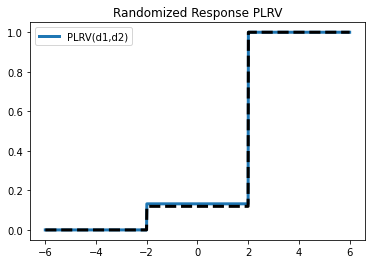

In [ ]:
def rr_cdf(z, epsilon=2): # this is what we think the cdf is
    if z < -2:
      return 0
    elif z < 2:
      return 1/(1+np.exp(epsilon))
    else:
      return 1

x = plot_rr_plrv(epsilon=2) # prepare plot and get x values
y = [rr_cdf(z, epsilon=2) for z in x] # get the y values for the cdf
plt.plot(x,y, "k--", lw=3) # plot them
plt.show() # show the plot of the estimated cdf plot_rr_plrv and our guessed cdf

#### Geometric Mechanism

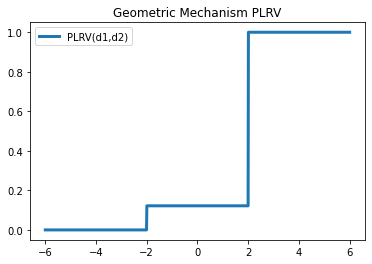

In [ ]:
def geometric_mechanism(d1, epsilon):
    p = 1-np.exp(-epsilon)
    return d1 + geometric.rvs(p) - geometric.rvs(p)

  
def geo_logpmf(output, d1, epsilon):
    p = 1-np.exp(-epsilon)
    return -np.abs(output-d1)*epsilon - np.log(1+np.exp(-epsilon)) + np.log(1-np.exp(-epsilon))


def plot_geo_plrv(epsilon=2, num_samples=1_000, num_points=1_000, title="Geometric Mechanism PLRV"):
    d1 = 1
    d2 = 0
    return plot_plrv(d1, d2, geometric_mechanism, (epsilon,), geo_logpmf, num_samples=num_samples, num_points=num_points, both=False, title=title)



x=plot_geo_plrv()
plt.show()

#### Group Privacy: 
Randomized Response vs. Geometric:
D1 = (0, 0)
D2 = (1, 1)
What is the Group PLRV of the Geometric Mechanism?
What is the Group PLRV of Randomized Response applied to each person?

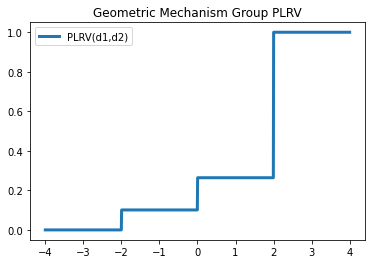

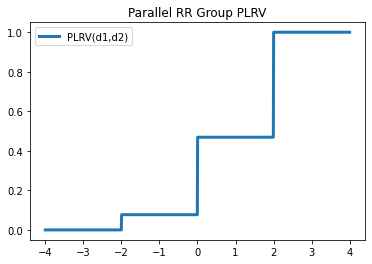

In [ ]:
def plot_geo_group_plrv(epsilon=1, num_samples=1_000, num_points=1_000, title="Geometric Mechanism Group PLRV"):
    d1 = 0
    d2 = 2
    return plot_plrv(d1, d2, geometric_mechanism, (epsilon,), geo_logpmf, num_samples=num_samples, num_points=num_points, both=False, title=title)

def parallel_rr(d1, epsilon):
    return (randomized_response(d1[0], epsilon), randomized_response(d1[1], epsilon))


def parallel_rr_logdensity(output, d1, epsilon):
    return rr_logdensity(output[0], d1[0], epsilon) + rr_logdensity(output[1], d1[1], epsilon)


def plot_rr_group_plrv(epsilon=1, num_samples=1_000, num_points=1_000, title="Parallel RR Group PLRV"):
    d1 = (0,0)
    d2 = (1,1)
    return plot_plrv(d1, d2, parallel_rr, (epsilon,), parallel_rr_logdensity, num_samples=num_samples, num_points=num_points, both=False,title=title)

plot_geo_group_plrv()
plt.show()
plot_rr_group_plrv()
plt.show()


#### Gaussian PLRV

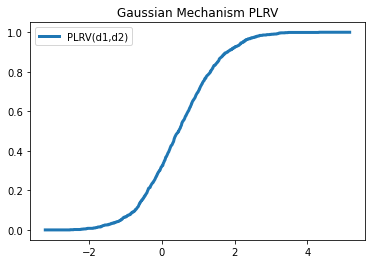

In [ ]:
def gaussian_mechanism(d1, sigma):
    return gaussian.rvs(loc=d1, scale=sigma)

  
def gauss_logdens(output, d1, sigma):
    return gaussian.logpdf(output, loc=d1, scale=sigma)


def plot_gauss_plrv(sigma=1, num_samples=1_000, num_points=1_000, title="Gaussian Mechanism PLRV"):
    d1 = 1
    d2 = 0
    return plot_plrv(d1, d2, gaussian_mechanism, (sigma,), gauss_logdens, num_samples=num_samples, num_points=num_points, both=False, title=title)


x=plot_gauss_plrv()
plt.show()


#### Laplace PLRV

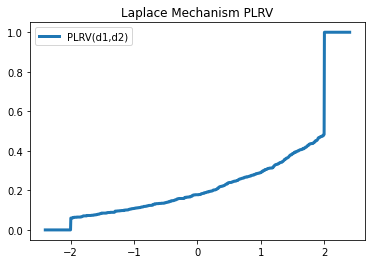

In [ ]:
def laplace_mechanism(d1, epsilon):
    return laplace.rvs(loc=d1, scale=1/epsilon)

  
def laplace_logdens(output, d1, epsilon):
    return laplace.logpdf(output, loc=d1, scale=1/epsilon)


def plot_laplace_plrv(epsilon=2, num_samples=1_000, num_points=1_000, title="Laplace Mechanism PLRV"):
    d1 = 1
    d2 = 0
    return plot_plrv(d1, d2, laplace_mechanism, (epsilon,), laplace_logdens, num_samples=num_samples, num_points=num_points, both=False,title=title)


x=plot_laplace_plrv()
plt.show()


#### Composition of Randomized Response PLRV

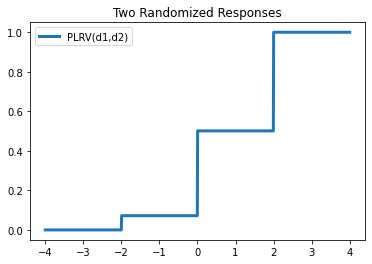

In [ ]:
def double_rr(d1, epsilon):
    return (randomized_response(d1, epsilon/2), randomized_response(d1, epsilon/2))


def double_rr_logdensity(output, d1, epsilon):
    a,b = output 
    return rr_logdensity(a, d1, epsilon/2) + rr_logdensity(b, d1, epsilon/2)


def plot_double_rr_plrv(epsilon=2, num_samples=1_000, num_points=1_000, title="Two Randomized Responses"):
    d1 = 1
    d2 = 0
    return plot_plrv(d1, d2, double_rr, (epsilon,), double_rr_logdensity, num_samples=num_samples, num_points=num_points, both=False,title=title)


x=plot_double_rr_plrv()
plt.show()

#### Composition vs. Components

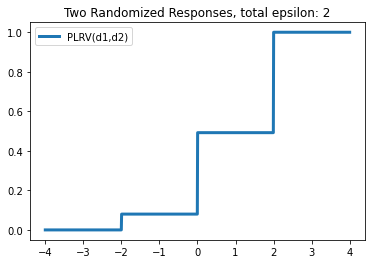

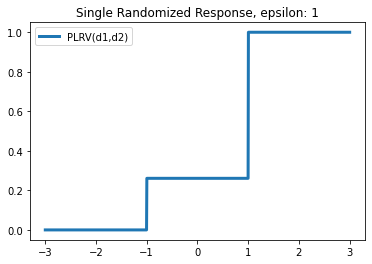

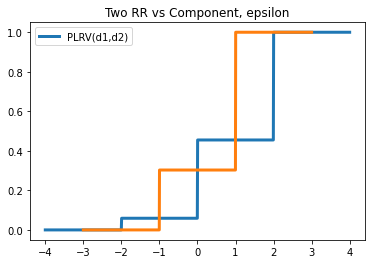

In [ ]:
def compare_rr():
    eps_double = 2
    eps_single = 1
    plot_double_rr_plrv(epsilon=eps_double, title=f"Two Randomized Responses, total epsilon: {eps_double}")
    plt.show()
    plot_rr_plrv(epsilon=eps_single, title=f"Single Randomized Response, epsilon: {eps_single}")
    plt.show()
    plot_double_rr_plrv(epsilon=eps_double, title="")
    plot_rr_plrv(epsilon=eps_single, title="Two RR vs Component, epsilon")
    plt.show()
compare_rr()


# Significance Level/Power Tradeoff


#### Setup code

In [ ]:
import bisect

def joint_cdf_helper(x, thecdf, sorted_samples):
    numless = 0  # used to compute value of cdf at a point
    value_index = 0
    num_samples = sorted_samples.size
    for i in range(x.size):
        point = x[i]
        # compute number of sorted samples <= x[i]
        while value_index < num_samples and sorted_samples[value_index] <= point:
          numless = numless + 1
          value_index = value_index + 1
        thecdf[i] = numless / num_samples



def joint_cdf(sample1, sample2, num_points):
    """ Returns the cdf of sample1 and sample2 evaluated at the same gridpoints: x, sample1_cdf, sample2_cdf """
    sorted_samples_1 = np.array(sorted(sample1))
    sorted_samples_2 = np.array(sorted(sample2))

    # get left and right endpoints for which we want the cdf     
    smallest_value = min(sorted_samples_1.min(), sorted_samples_2.min())
    largest_value = max(sorted_samples_1.max(), sorted_samples_2.max())
    therange = largest_value - smallest_value 
    left = smallest_value - 1
    right = largest_value + 1

    # create the common x value and initialize the two cdfs
    x = np.linspace(left, right, num_points+2)
    y_1 = np.zeros(x.size)
    y_2 = np.zeros(x.size)

    joint_cdf_helper(x, y_1, sorted_samples_1)
    joint_cdf_helper(x, y_2, sorted_samples_2)

    return x, y_1, y_2

def get_power_from_level(level, h0_cdf, h1_cdf):
    """ Given the cdf of a plrv (h0_cdf) and the cdf of the negative of the revese plrv (h1_cdf) and a desired level, compute the power """
    index = bisect.bisect_right(h0_cdf, level)
    if index == 0:
      return h1_cdf[0]
    else:
      c = (level - h0_cdf[index-1])/(h0_cdf[index] - h0_cdf[index-1])
      return c*h1_cdf[index] + (1-c) * h1_cdf[index-1]


def level_power_tradeoff(d1, d2, mechanism, mech_params, logdensity, num_samples=100_000, num_points=1_000, title=""):
    """ computes the maximum power achievable for every significance level """
    level_samples = sample_plrv(d1, d2, mechanism, mech_params, logdensity, num_samples=num_samples)
    power_samples = -1 * sample_plrv(d2, d1, mechanism, mech_params, logdensity, num_samples=num_samples)
    x,cdf_for_level, cdf_for_power = joint_cdf(level_samples, power_samples, num_points=num_points)
    c_values = [0, 0.25, 0.5, 0.75, 1]
    level_list = np.zeros(x.size-1)
    power_list = np.zeros(x.size-1)
    for i in range(1, x.size):
        for c in c_values:
            level = (1-c) * cdf_for_level[i-1] + c * cdf_for_level[i]
            power = (1-c) * cdf_for_power[i-1] + c * cdf_for_power[i]
            level_list[i-1] = level
            power_list[i-1] = power
    plt.plot(level_list, power_list, lw=3)
    plt.xlabel("Significance Level")
    plt.ylabel("Power")
    plt.title(title)
    plt.show()

    desired_levels = [0.01, 0.05, 0.1]
    for dl in desired_levels:
        power = get_power_from_level(dl, cdf_for_level, cdf_for_power)
        print(f"Significance Level: {dl}, Power: {power}")

#### Tradeoff for Randomized Response

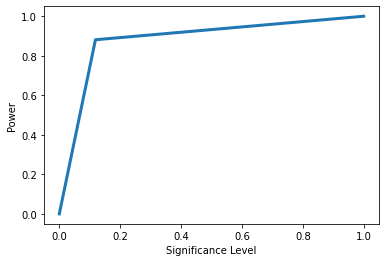

Significance Level: 0.01, Power: 0.07419284210526317
Significance Level: 0.05, Power: 0.37096421052631584
Significance Level: 0.1, Power: 0.7419284210526317


In [ ]:
def rr_tradeoff(epsilon=2, num_samples=100_000, num_points=1_000):
    d1 = 1 
    d2 = 0
    level_power_tradeoff(d1, d2, randomized_response, (epsilon,), rr_logdensity, num_samples=num_samples, num_points=num_points)

rr_tradeoff()


#### Tradeoff for the Geometric Mechanism

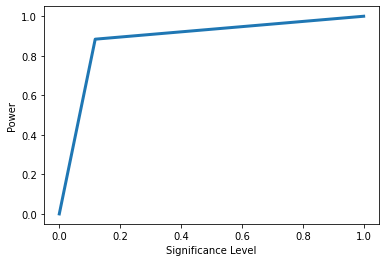

Significance Level: 0.01, Power: 0.07490001694628029
Significance Level: 0.05, Power: 0.3745000847314015
Significance Level: 0.1, Power: 0.749000169462803


In [ ]:
def geo_tradeoff(epsilon=2, num_samples=100_000, num_points=1_000):
    d1 = 1 
    d2 = 0
    level_power_tradeoff(d1, d2, geometric_mechanism, (epsilon,), geo_logpmf, num_samples=num_samples, num_points=num_points)

geo_tradeoff()


#### Tradeoff for the Laplace Mechanism

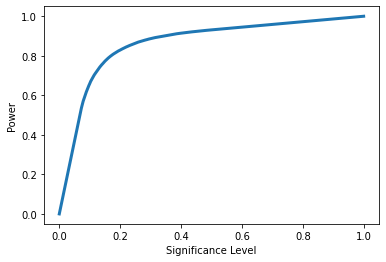

Significance Level: 0.01, Power: 0.07405521745584087
Significance Level: 0.05, Power: 0.3702760872792044
Significance Level: 0.1, Power: 0.659305


In [ ]:
def laplace_tradeoff(epsilon=2, num_samples=100_000, num_points=1_000):
    d1 = 1 
    d2 = 0
    level_power_tradeoff(d1, d2, laplace_mechanism, (epsilon,), laplace_logdens, num_samples=num_samples, num_points=num_points)

laplace_tradeoff()

#### Tradeoff for the composition of two randomized responses

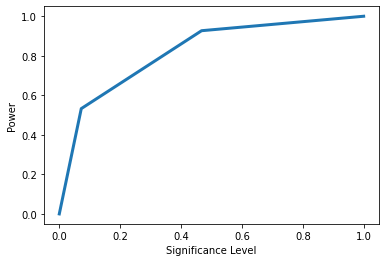

Significance Level: 0.01, Power: 0.07375657712545002
Significance Level: 0.05, Power: 0.36878288562725003
Significance Level: 0.1, Power: 0.5603712911712623


In [ ]:
def double_rr_tradeoff(epsilon=2, num_samples=100_000, num_points=1_000):
    d1 = 1 
    d2 = 0
    level_power_tradeoff(d1, d2, double_rr, (epsilon,), double_rr_logdensity, num_samples=num_samples, num_points=num_points)

double_rr_tradeoff()


#### Tradeoff for the Gaussian

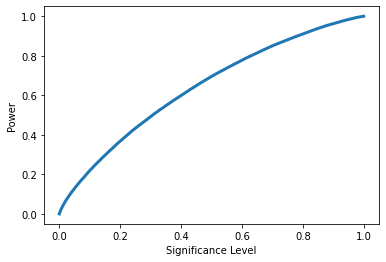

Significance Level: 0.01, Power: 0.03581975
Significance Level: 0.05, Power: 0.1291267391304348
Significance Level: 0.1, Power: 0.21867328358208954


In [ ]:
def gauss_tradeoff(sigma=2, num_samples=100_000, num_points=1_000):
    d1 = 1 
    d2 = 0
    level_power_tradeoff(d1, d2, gaussian_mechanism, (sigma,), gauss_logdens, num_samples=num_samples, num_points=num_points)

gauss_tradeoff()
